In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
import time
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
# группировка по классу и возрасту
def age_impute(train, test):
    for i in [train, test]:
        i['Age_Null_Flag'] = i['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)
        data = train.groupby(['Pclass'])['Age']
        i['Age'] = data.transform(lambda x: x.fillna(x.mean()))
    return train, test

In [4]:
# переход от категорильаных данных к числовым меткам
def dummies(train, test, columns):
    if columns is None:
        columns = ['Pclass', 'Sex', 'Embarked']
    for column in columns:
        train[column] = train[column].apply(lambda x: str(x))
        test[column] = test[column].apply(lambda x: str(x))
        good_cols = [column+'_'+i for i in train[column].unique() if i in test[column].unique()]
        train = pd.concat((train, pd.get_dummies(train[column], prefix = column)[good_cols]), axis = 1)
        test = pd.concat((test, pd.get_dummies(test[column], prefix = column)[good_cols]), axis = 1)
        del train[column]
        del test[column]
    return train, test

In [5]:
# удаление ненужных столбцов
def drop(train, test, bye):
    for i in [train, test]:
        for z in bye:
            del i[z]
    return train, test

In [6]:
train, test = age_impute(train, test)
test['Fare'].fillna(train['Fare'].mean(), inplace = True)
train, test = dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked'])
train, test = drop(train, test, bye = ['PassengerId', 'Name','SibSp',	'Parch','Ticket', 'Cabin'])

In [7]:
train.head()

,Survived,Age,Fare,Age_Null_Flag,Pclass_3,Pclass_1,Pclass_2,Sex_male,Sex_female,Embarked_S,Embarked_C,Embarked_Q
0,0,22.0,7.2500,0,True,False,False,True,False,True,False,False
1,1,38.0,71.2833,0,False,True,False,False,True,False,True,False
2,1,26.0,7.9250,0,True,False,False,False,True,True,False,False
3,1,35.0,53.1000,0,False,True,False,False,True,True,False,False
4,0,35.0,8.0500,0,True,False,False,True,False,True,False,False


In [8]:
X_train, X_test, y_train, y_test = train_test_split(train.iloc[:, 1:], train.iloc[:, 0], test_size=0.2, random_state=42)

In [9]:
# Инициализация и обучение моделей
models = {
    "CatBoost": CatBoostClassifier(),
    "LightGBM": LGBMClassifier(),
    "XGBoost": XGBClassifier(),
    "AdaBoost": AdaBoostClassifier()
}

In [10]:
results = {}
for name, model in models.items():
    start_time = time.time()  # Начало отсчета времени обучения
    model.fit(X_train, y_train)
    train_time = time.time() - start_time  # Время обучения

    start_time = time.time()  # Начало отсчета времени предсказания
    y_pred = model.predict(X_test)
    predict_time = time.time() - start_time  # Время предсказания

    accuracy = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results[name] = {
        "Accuracy": accuracy,
        "Confusion Matrix": confusion,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
        "Training Time": train_time,
        "Prediction Time": predict_time
    }

# Вывод результатов
for name, metrics in results.items():
    print(f"Модель: {name}")
    print(f"Точность: {metrics['Accuracy']}")
    print(f"Матрица ошибок: \n{metrics['Confusion Matrix']}")
    print(f"Точность (Precision): {metrics['Precision']}")
    print(f"Полнота (Recall): {metrics['Recall']}")
    print(f"F1-мера: {metrics['F1-score']}")
    print(f"Время обучения: {metrics['Training Time']} секунд")
    print(f"Время предсказания: {metrics['Prediction Time']} секунд")
    print("---------------------")

Learning rate set to 0.008911
0:	learn: 0.6866226	total: 58ms	remaining: 58s
1:	learn: 0.6821523	total: 58.8ms	remaining: 29.3s
2:	learn: 0.6775107	total: 59.9ms	remaining: 19.9s
3:	learn: 0.6735994	total: 60.4ms	remaining: 15s
4:	learn: 0.6686213	total: 61ms	remaining: 12.1s
5:	learn: 0.6628113	total: 62.1ms	remaining: 10.3s
6:	learn: 0.6571436	total: 63.3ms	remaining: 8.97s
7:	learn: 0.6515392	total: 64.3ms	remaining: 7.98s
8:	learn: 0.6469909	total: 64.9ms	remaining: 7.14s
9:	learn: 0.6417137	total: 65.8ms	remaining: 6.52s
10:	learn: 0.6365314	total: 66.8ms	remaining: 6s
11:	learn: 0.6315006	total: 67.7ms	remaining: 5.58s
12:	learn: 0.6262800	total: 68.7ms	remaining: 5.22s
13:	learn: 0.6217096	total: 69.7ms	remaining: 4.91s
14:	learn: 0.6174235	total: 70.4ms	remaining: 4.62s
15:	learn: 0.6128037	total: 71.3ms	remaining: 4.39s
16:	learn: 0.6081013	total: 72.3ms	remaining: 4.18s
17:	learn: 0.6035035	total: 73.3ms	remaining: 4s
18:	learn: 0.5992725	total: 74.3ms	remaining: 3.83s
19:	le

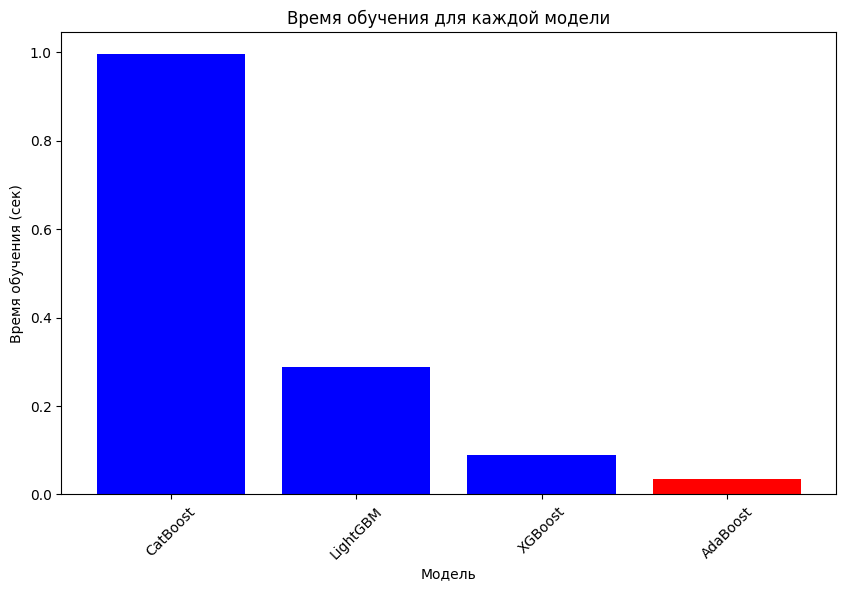

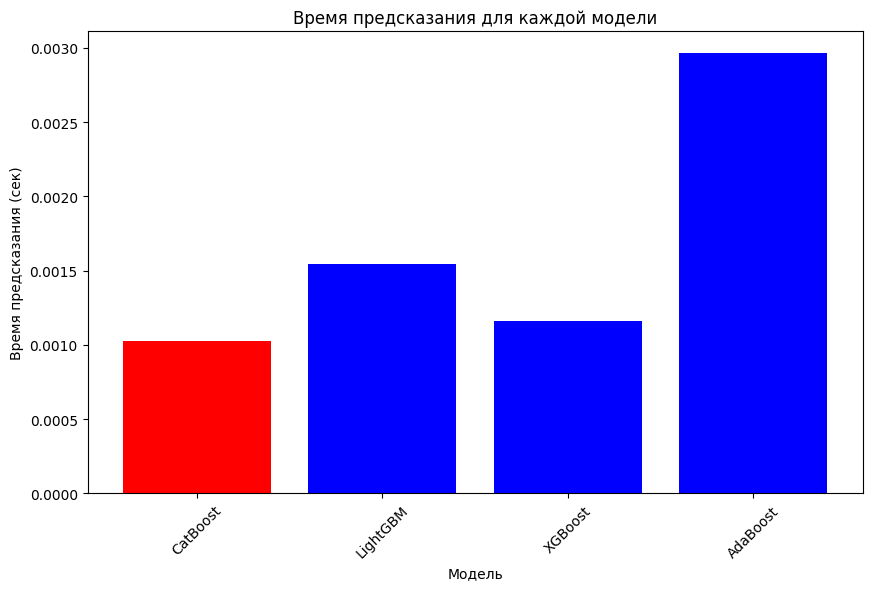

In [11]:
import matplotlib.pyplot as plt

model_names = list(results.keys())
training_times = [result["Training Time"] for result in results.values()]
prediction_times = [result["Prediction Time"] for result in results.values()]

# График времени обучения
plt.figure(figsize=(10, 6))
plt.bar(model_names, training_times, color=['red' if t == min(training_times) else 'blue' for t in training_times])
plt.xlabel('Модель')
plt.ylabel('Время обучения (сек)')
plt.title('Время обучения для каждой модели')
plt.xticks(rotation=45)
plt.show()

# График времени предсказания
plt.figure(figsize=(10, 6))
plt.bar(model_names, prediction_times, color=['red' if t == min(prediction_times) else 'blue' for t in prediction_times])
plt.xlabel('Модель')
plt.ylabel('Время предсказания (сек)')
plt.title('Время предсказания для каждой модели')
plt.xticks(rotation=45)
plt.show()

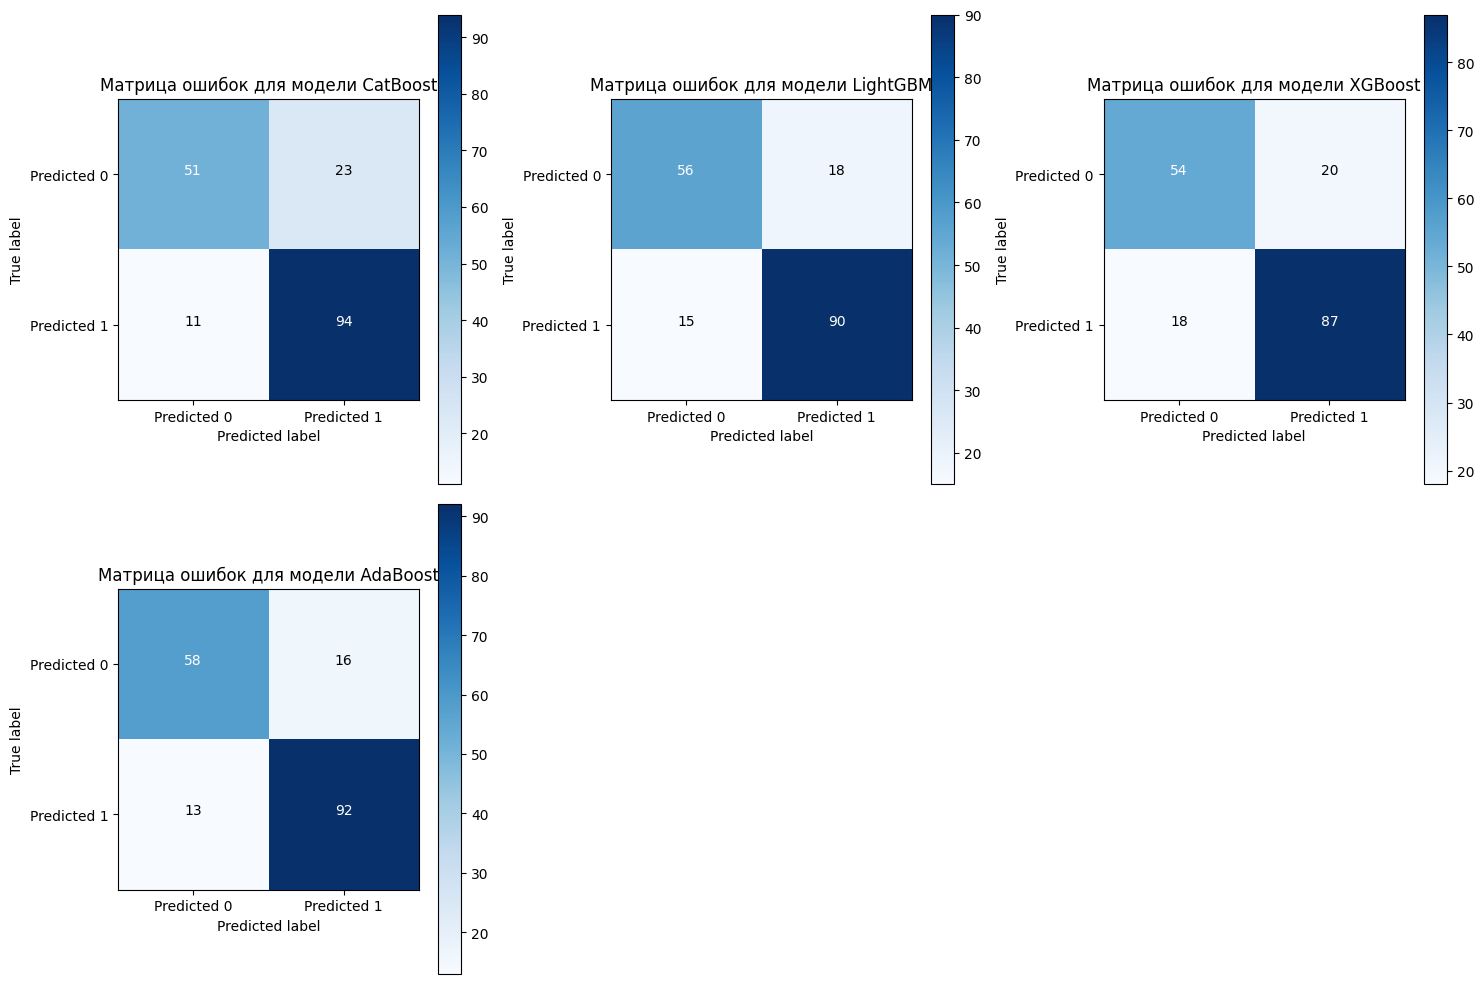

In [12]:
import matplotlib.pyplot as plt
import numpy as np

model_names = list(results.keys())
confusion_matrices = [result["Confusion Matrix"] for result in results.values()]

plt.figure(figsize=(15, 10))

for i, matrix in enumerate(confusion_matrices):
    matrix[[0, 1]] = matrix[[1, 0]]
    matrix[:, [0, 1]] = matrix[:, [1, 0]]

    plt.subplot(2, 3, i + 1)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Матрица ошибок для модели {model_names[i]}')
    plt.colorbar()

    classes = ['Predicted 0', 'Predicted 1']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = matrix.max() / 2.
    for x in range(matrix.shape[0]):
        for y in range(matrix.shape[1]):
            plt.text(y, x, format(matrix[x, y], fmt),
                     horizontalalignment="center",
                     color="white" if matrix[x, y] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.tight_layout()
plt.show()

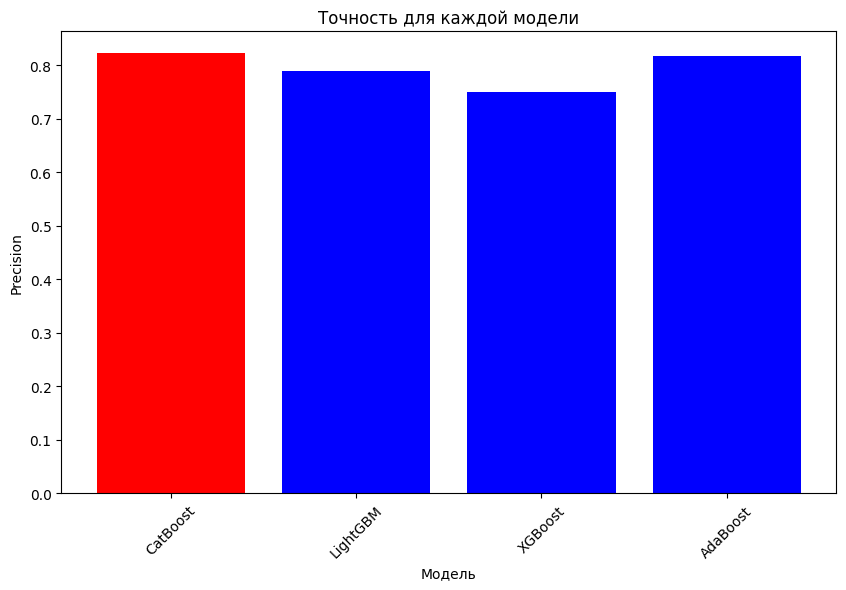

In [13]:
import matplotlib.pyplot as plt

precision_values = [result["Precision"] for result in results.values()]
recall_values = [result["Recall"] for result in results.values()]
f1_values = [result["F1-score"] for result in results.values()]

best_precision_idx = precision_values.index(max(precision_values))
best_recall_idx = recall_values.index(max(recall_values))
best_f1_idx = f1_values.index(max(f1_values))

plt.figure(figsize=(10, 6))
plt.bar(model_names, precision_values, color=['red' if i == best_precision_idx else 'blue' for i in range(len(model_names))])
plt.xlabel('Модель')
plt.ylabel('Precision')
plt.title('Точность для каждой модели')
plt.xticks(rotation=45)
plt.show()

In [14]:
from sklearn.datasets import fetch_olivetti_faces
import matplotlib.pyplot as plt

In [15]:
#Если параметр return_X_y установлен в True, функция fetch_olivetti_faces вернет кортеж из двух элементов: data и target
data, target = fetch_olivetti_faces(return_X_y=True)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /Users/prokhor/scikit_learn_data


In [16]:
from sklearn.model_selection import train_test_split

X = data
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

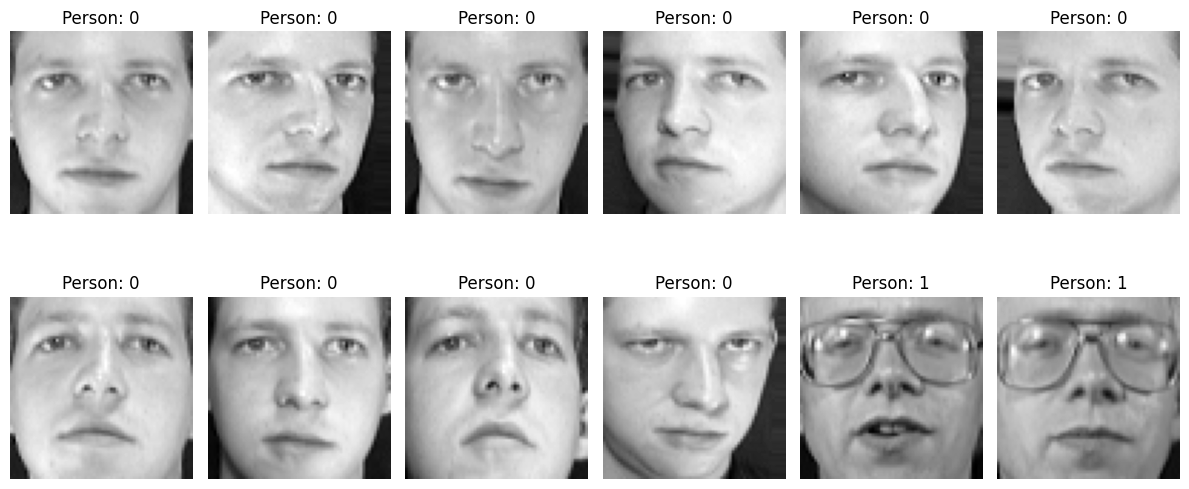

In [17]:
num_samples = 12

plt.figure(figsize=(12, 6))
for i in range(num_samples):
    plt.subplot(2, num_samples // 2, i + 1)
    plt.imshow(X[i].reshape(64, 64), cmap='gray')
    plt.title(f"Person: {target[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [18]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
import time
from sklearn.metrics import mean_absolute_error, r2_score

In [19]:
models = {
   "CatBoost": CatBoostRegressor(random_state=42),
    "LightGBM": LGBMRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42)
}

In [20]:
results = {}
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    start_time = time.time()
    predictions = model.predict(X_test)
    predict_time = time.time() - start_time

    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    results[name] = {
        "MAE": mae,
        "R^2": r2,
        "Training Time": train_time,
        "Prediction Time": predict_time
    }

for name, result in results.items():
    print(f"Название модели: {name}")
    print(f"MAE: {result['MAE']}")
    print(f"R^2: {result['R^2']}")
    print(f"Время обучения: {result['Training Time']} seconds")
    print(f"Время на предсказание: {result['Prediction Time']} seconds")
    print("---------------------")

Learning rate set to 0.034197
0:	learn: 11.1554296	total: 65.2ms	remaining: 1m 5s
1:	learn: 11.0237663	total: 112ms	remaining: 56.1s
2:	learn: 10.8945045	total: 157ms	remaining: 52.2s
3:	learn: 10.8202903	total: 200ms	remaining: 49.9s
4:	learn: 10.6994209	total: 245ms	remaining: 48.8s
5:	learn: 10.5834543	total: 290ms	remaining: 48s
6:	learn: 10.4679881	total: 335ms	remaining: 47.5s
7:	learn: 10.3462737	total: 382ms	remaining: 47.4s
8:	learn: 10.2290078	total: 426ms	remaining: 46.9s
9:	learn: 10.1153048	total: 472ms	remaining: 46.8s
10:	learn: 10.0279283	total: 515ms	remaining: 46.3s
11:	learn: 9.9446018	total: 559ms	remaining: 46.1s
12:	learn: 9.8580568	total: 606ms	remaining: 46s
13:	learn: 9.7806754	total: 651ms	remaining: 45.9s
14:	learn: 9.6832615	total: 696ms	remaining: 45.7s
15:	learn: 9.5915845	total: 742ms	remaining: 45.6s
16:	learn: 9.4989628	total: 789ms	remaining: 45.6s
17:	learn: 9.4014354	total: 835ms	remaining: 45.5s
18:	learn: 9.2775032	total: 881ms	remaining: 45.5s
19:

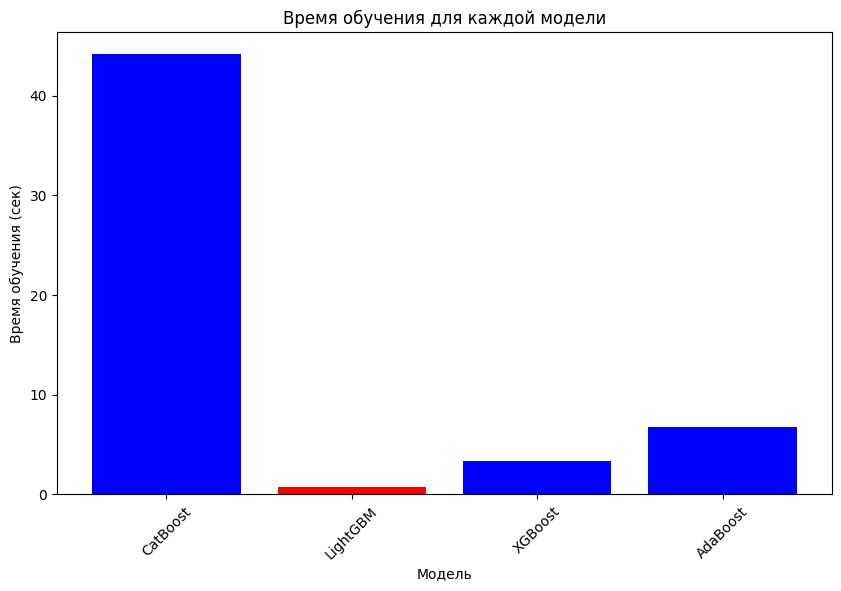

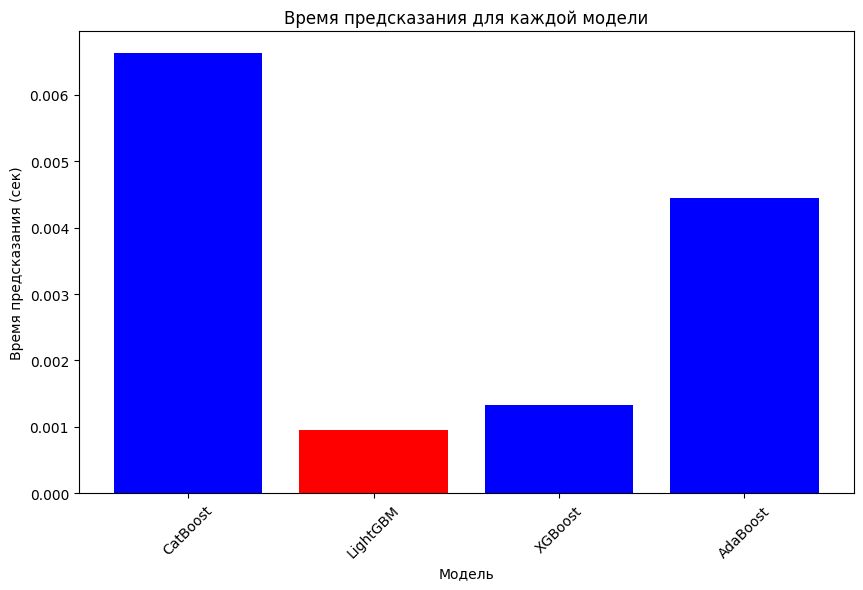

In [21]:
import matplotlib.pyplot as plt

model_names = list(results.keys())
training_times = [result["Training Time"] for result in results.values()]
prediction_times = [result["Prediction Time"] for result in results.values()]

# График времени обучения
plt.figure(figsize=(10, 6))
plt.bar(model_names, training_times, color=['red' if t == min(training_times) else 'blue' for t in training_times])
plt.xlabel('Модель')
plt.ylabel('Время обучения (сек)')
plt.title('Время обучения для каждой модели')
plt.xticks(rotation=45)
plt.show()

# График времени предсказания
plt.figure(figsize=(10, 6))
plt.bar(model_names, prediction_times, color=['red' if t == min(prediction_times) else 'blue' for t in prediction_times])
plt.xlabel('Модель')
plt.ylabel('Время предсказания (сек)')
plt.title('Время предсказания для каждой модели')
plt.xticks(rotation=45)
plt.show()

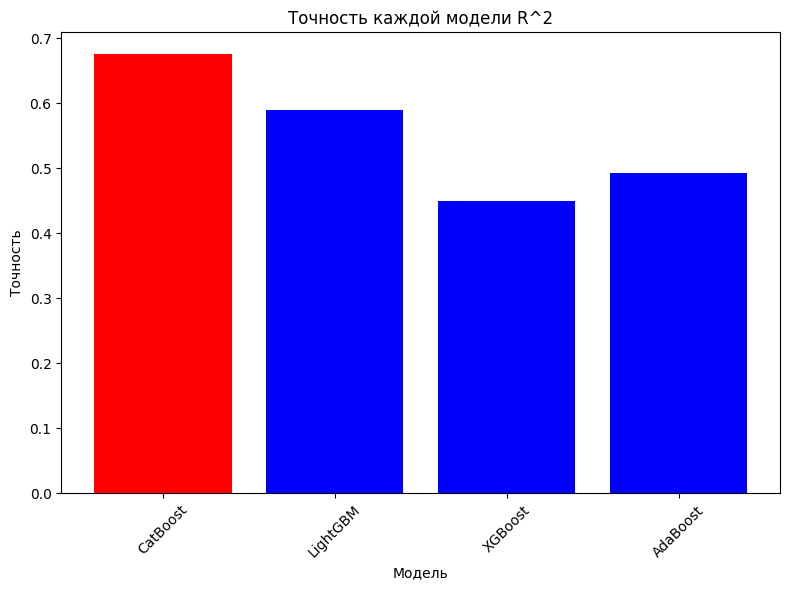

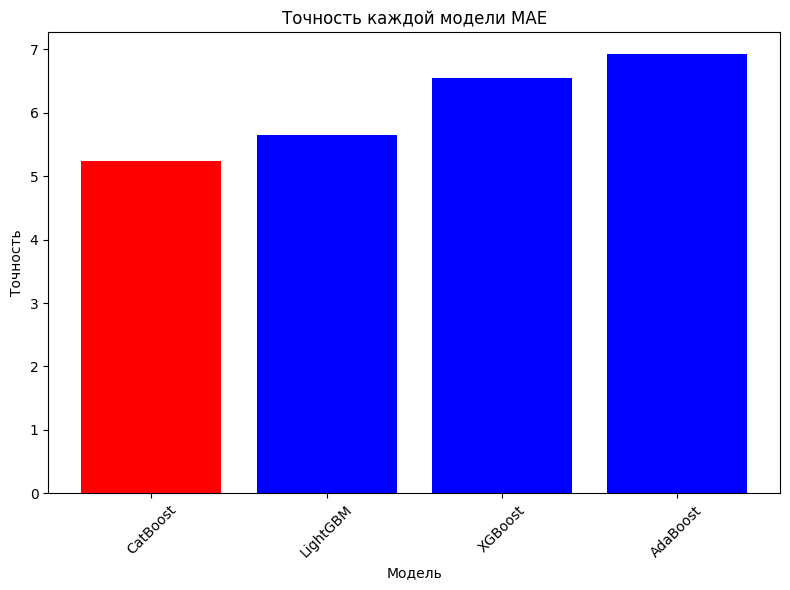

In [22]:
import matplotlib.pyplot as plt

accuracies = [result["R^2"] for result in results.values()]
model_names = list(results.keys())
best_r2_idx = accuracies.index(max(accuracies))

plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracies, color=['red' if i == best_r2_idx else 'blue' for i in range(len(model_names))])
plt.xlabel('Модель')
plt.ylabel('Точность')
plt.title('Точность каждой модели R^2')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

accuracies = [result["MAE"] for result in results.values()]
best_mae_idx = accuracies.index(min(accuracies))

plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracies, color=['red' if i == best_mae_idx else 'blue' for i in range(len(model_names))])
plt.xlabel('Модель')
plt.ylabel('Точность')
plt.title('Точность каждой модели MAE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
